In [39]:
import pandas as pd
from google.colab import files


In [8]:
df = pd.read_csv("/content/Superstore.csv", encoding='ISO-8859-1')
print("File loaded successfully ✅")
print(df.head())



File loaded successfully ✅
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688  2016-06-12  2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Categ

In [11]:
df.drop_duplicates(inplace=True)


In [12]:
df.dropna(axis=1, how='all', inplace=True)


In [13]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(0)


In [14]:
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')


In [15]:
for col in df.columns:
    if 'Date' in col:
        df[col] = pd.to_datetime(df[col], errors='coerce')


In [16]:
df.dropna(subset=[col for col in df.columns if 'Date' in col], inplace=True)


In [17]:
df.reset_index(drop=True, inplace=True)


In [18]:
cleaned_path = "/content/Cleaned_Superstore.csv"
df.to_csv(cleaned_path, index=False)
print("✅ Cleaned file ready:", cleaned_path)


✅ Cleaned file ready: /content/Cleaned_Superstore.csv


In [19]:
files.download(cleaned_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!pip install xgboost matplotlib seaborn scikit-learn pandas --quiet

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier


In [21]:
df = pd.read_csv("/content/Cleaned_Superstore.csv")


In [22]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year


In [23]:
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()
monthly_sales['Next_Month_Sales'] = monthly_sales['Sales'].shift(-1)
monthly_sales.dropna(inplace=True)


In [24]:
X_reg = monthly_sales[['Year', 'Month', 'Sales']]
y_reg = monthly_sales['Next_Month_Sales']


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)


In [26]:
reg_model = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
)


In [27]:
reg_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
y_pred = reg_model.predict(X_test)


In [29]:
print("\n📈 REGRESSION RESULTS:")
print("R²:", round(r2_score(y_test, y_pred), 3))



📈 REGRESSION RESULTS:
R²: 0.218


In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", round(rmse, 2))


RMSE: 21068.12


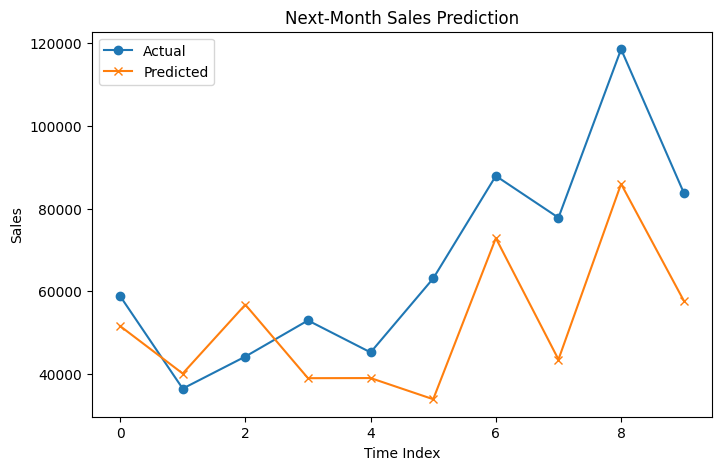

In [31]:
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Next-Month Sales Prediction")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [32]:
df['Profit_Label'] = (df['Profit'] > 0).astype(int)


In [33]:
cat_cols = ['Category', 'Sub-Category', 'Region', 'Segment', 'Ship Mode']
le = LabelEncoder()
for col in cat_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

X_cls = df[['Sales', 'Quantity', 'Discount', 'Category', 'Sub-Category',
            'Region', 'Segment', 'Ship Mode']]
y_cls = df['Profit_Label']


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

In [35]:
cls_model = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42
)
cls_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [36]:
y_pred = cls_model.predict(X_test)


In [37]:
print("\n💰 CLASSIFICATION RESULTS:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))



💰 CLASSIFICATION RESULTS:
Accuracy: 0.946
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       377
           1       0.96      0.98      0.97      1622

    accuracy                           0.95      1999
   macro avg       0.92      0.89      0.91      1999
weighted avg       0.94      0.95      0.94      1999



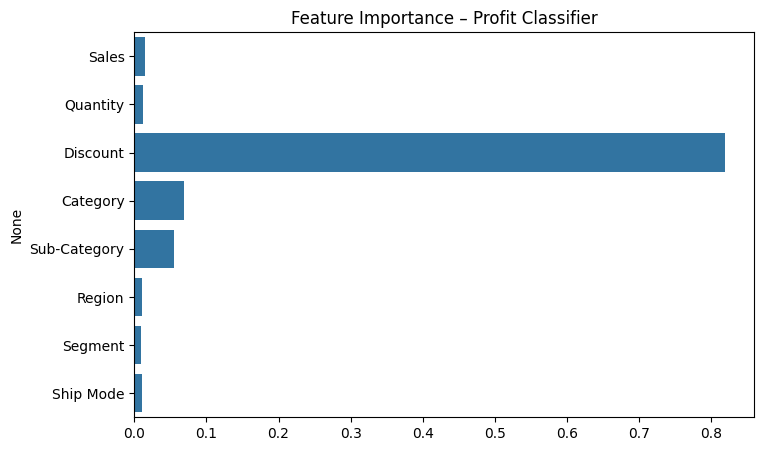

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(x=cls_model.feature_importances_, y=X_cls.columns)
plt.title("Feature Importance – Profit Classifier")
plt.show()
